In [5]:
!pip install pandas
!pip install torch
!pip install poser
!pip install numpy
!pip install torchvision
!pip install napari
!pip install torchmetrics
!pip install matplotlib
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 27.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.9/774.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 30.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/58

In [25]:
pip uninstall poser

Found existing installation: poser 0.2.3
Uninstalling poser-0.2.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/poser-0.2.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/poser.py
^Coceed (Y/n)? 
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [21]:
import sys
sys.path.insert(0, "/home/jovyan/work/src/poser/")

import poser
print(poser.__file__)


/usr/local/lib/python3.10/dist-packages/poser.py


In [20]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
import os
import poser
from poser.utils import convert_dlc_to_ctvm
from poser._widget import PoserWidget
from napari import Viewer
import torch
from torchmetrics.functional.classification import multiclass_accuracy
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns   
import time

ModuleNotFoundError: No module named 'poser.utils'; 'poser' is not a package

1) use best model config, create poser widget and call with batch size 16 - training time should be saved in checkpoint file name and logger
2) use best model and associated config and run prediction on an example video with 

In [2]:
viewer = Viewer()
wid = PoserWidget(viewer)
viewer.window.add_dock_widget(wid, area='right')


#### ZebLR
1) Bout extraction mode
2) Frame by frame bout


In [ ]:
decoder_dir = "./ZebLR"
wid.decoder_dir_picker.value = decoder_dir
wid.chkpt_dropdown.choices#best checkpoint is last one
chkpt = wid.chkpt_dropdown.choices[0]
# test the model on test data set
# test the model on one video of length 40 minutes filmed at 330 fps under 2 conditions; every frame and only extracted bouts
# 1) Load dlc file, 2) extract bouts, 3) convert to ctvm, 4) predict, 5) plot

dlc_file = r"C:\Users\pierc\Documents\DecoderData\ZebLR\Fish85_Wik_7dpf_330HzDLC_resnet50_Zeb2_0Feb4shuffle1_500000.h5"
vid_file = r"C:\Users\pierc\Documents\DecoderData\ZebLR\Fish85_Wik_7dpf_330Hz.avi"
wid.h5_picker.value = dlc_file
wid.vid_picker.value = vid_file
#wid.h5_picker_changed(dlc_file)
#wid.vid_picker_changed(vid_file)
wid.ind_spinbox.value = 1

start_time = time.time()
wid.extract_behaviours()
wid.analyse(None)
end_time = time.time()
duration = end_time - start_time
print(f"Bout analysis took {duration} seconds")

# frame by frame
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = os.path.join(decoder_dir, chkpt)
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


CTVM = convert_dlc_to_ctvm(dlc_file)
window_size =( 330. / 8 ) * 2
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 300, center_node = 13, preprocess_frame=True, window_size = 14)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

Video File Changed to c:\Users\pierc\Documents\DecoderData
Layers remaining are []
Layers remaining are []
Decoder Data Folder is c:\Users\pierc\Documents\DecoderData\ZebLR
Center node is 13
Number of nodes is 19
not regression
transform is None
Augmenting data True
Label dict is {0: 0, 1: 1, 2: 2}
decoder config is {'data_cfg': {'T': 'window', 'V': 19, 'fps': 330.0, 'T2': 300, 'numLabels': 3, 'denominator': 8, 'center': 13, 'classification_dict': {0: 0, 1: 1, 2: 2}, 'labels_to_ignore': 'None', 'augmentation': True, 'calc_class_weights': False, 'weighted_random_sampler': True, 'ideal_sample_no': 10000}, 'train_cfg': {'devices': 1, 'auto_lr': True, 'accelerator': 'gpu', 'graph_layout': 'zebrafishlarvae', 'dropout': 0, 'num_channels': 3, 'num_workers': 0, 'transform': 'None', 'backbone': 'ST-GCN', 'early_stop_metric': 'auprc', 'early_stop_mode': 'max', 'patience': 3, 'freeze': False, 'numRuns': 1}}
DLC File Changed to C:\Users\pierc\Documents\DecoderData\ZebLR\Fish85_Wik_7dpf_330HzDLC_re

c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\napari\_vispy\layers\image.py:242: UserWarning: data shape (3, 780065) exceeds GL_MAX_TEXTURE_SIZE 32768 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


Extracting behaviours using orth method
Layers remaining are []


C:\Users\pierc\OneDrive\Documents\PoseR\src\poser\_widget.py:1011: RuntimeWarning: invalid value encountered in divide
  (np.sum(future_trajectory * present_orth, axis=1))


Augment is False
not regression
transform is None
Augmenting data True
Label dict is {0: 0, 1: 1, 2: 2}
Binary is False


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Binary is False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 55/55 [00:02<00:00, 21.94it/s]
Total prediction time: 2.5193 seconds
tensor([[ -1.9328,  -8.6944,  -1.1693],
        [ -1.7278, -15.4360,   6.3702],
        [  1.2970,   7.2140, -10.0023],
        ...,
        [ -0.1562,  24.2281, -45.1163],
        [  1.1087,   6.3991,  -8.1019],
        [  0.8378,   6.3921,  -7.7454]])
<class 'numpy.ndarray'>
predictions is [2 2 1 2 2 1 2 2 2 2 2 1 1 1 1 1 1 2 2 2 1 2 2 2 2 1 2 1 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 2 0 1 1 1 1 1 1 1 0 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 2 2 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 0 2 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0
 1 1 2 2 0 0 1 1 2 1 1 1 2 1 0 2 1 2 1 0 0 1 1 1 0 0 1

c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\napari\_vispy\layers\image.py:242: UserWarning: data shape (3, 780065) exceeds GL_MAX_TEXTURE_SIZE 32768 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Bout analysis took 8.70335865020752 seconds


Augment is False


(<matplotlib.collections.PathCollection at 0x1e23b754820>,)

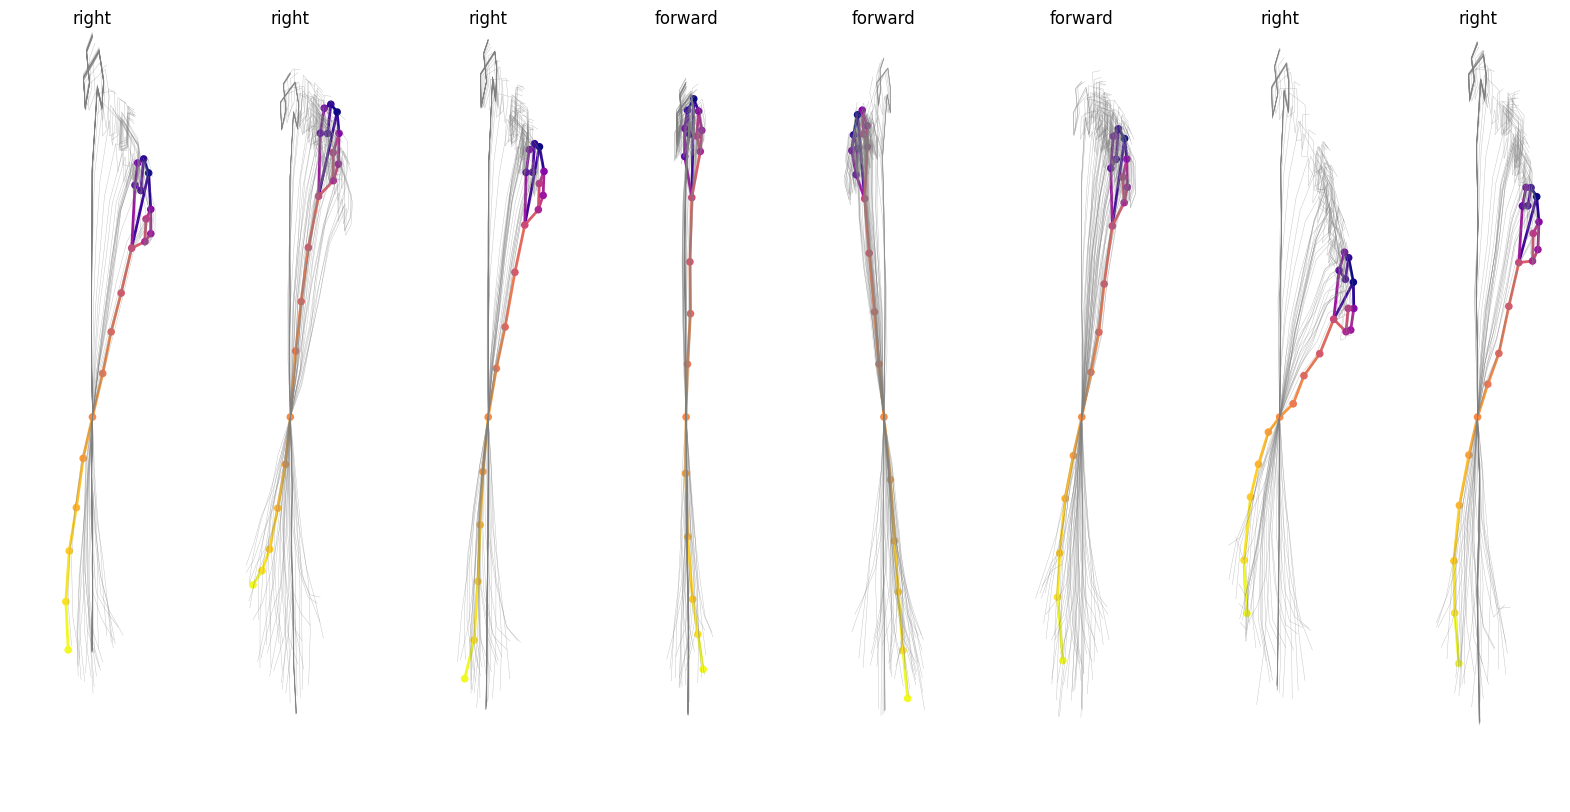

In [8]:
## oriningal dataset
from poser.utils import Animation
from poser._loader import ZebData
labels = np.load("./ZebLR/Zebtest_labels.npy")
behaviours = np.load("./ZebLR/Zebtest.npy")
zebdata = ZebData()
zebdata.data = behaviours
zebdata.labels = labels
# use the skeleton for zeb2.0
skeleton = [[0, 1], [0, 5], [1, 2], [1, 4], [2, 3], 
                [4, 3], [5, 6], [5, 8], [8, 7], [6, 7], 
                [7, 9], [3, 9], [0, 9], [9, 10], [10, 11],
                [11, 12], [12, 13], [13, 14], [14, 15],
                [15, 16], [16, 17], [17, 18]]
label_dict = {0:"forward", 1:"left", 2:"right"}
anima = Animation(zebdata, skeleton = skeleton, shuffle  =True, label_dict = label_dict, batch_size = 8)
iter_data = iter(anima.dataloader)
anima.behaviours, anima.labels = next(iter_data)
anima.fig, anima.axes = plt.subplots(ncols = anima.dataloader.batch_size, figsize = (20, 10))
anima.setup()
anima.update(50) # anima.T-1


(<matplotlib.collections.PathCollection at 0x1e2e07b5300>,)

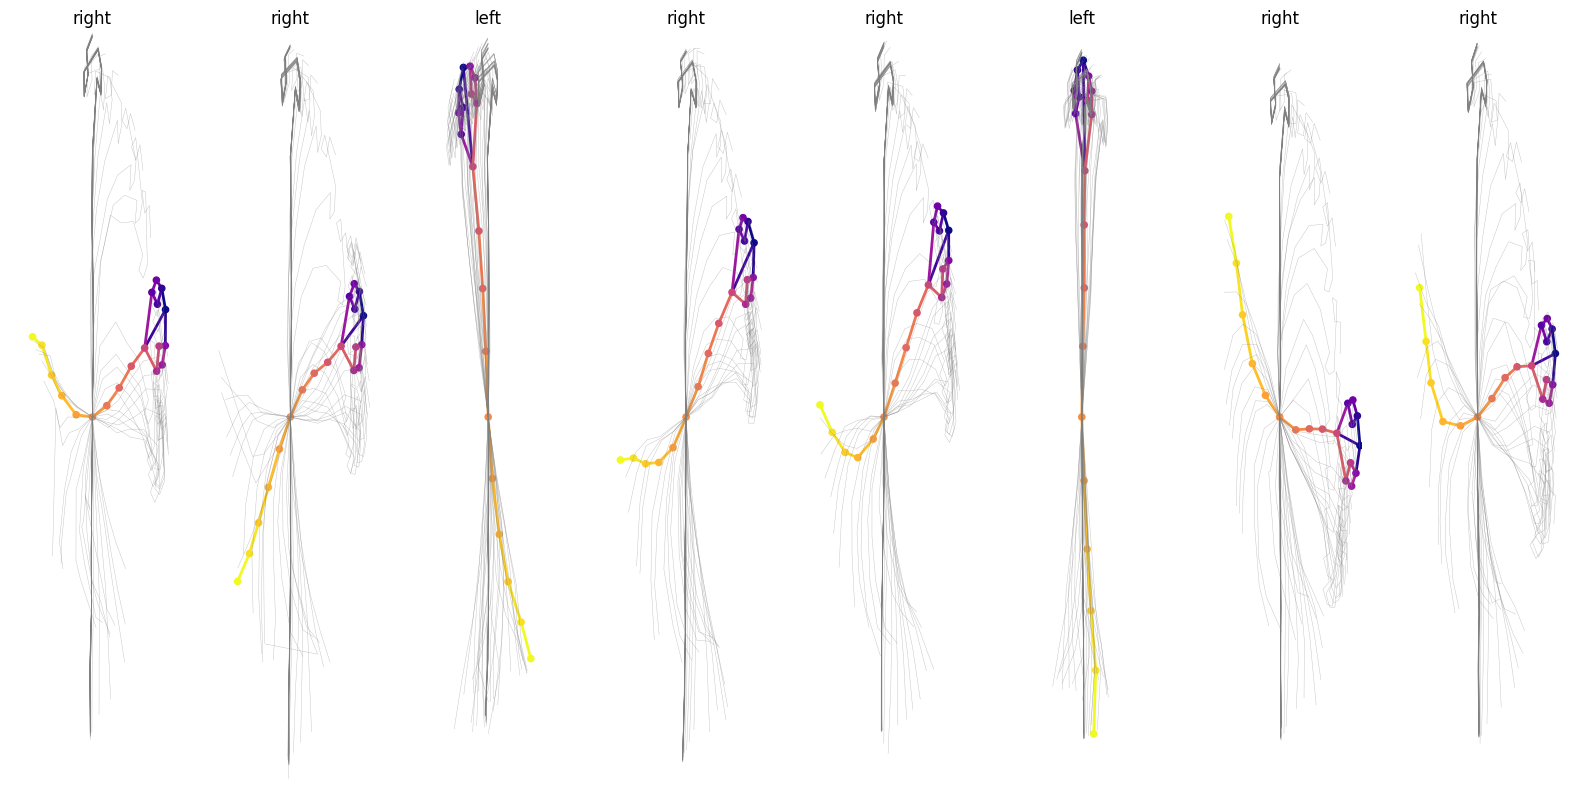

updating slider
Event
updating slider frame 381234
updating slider
Event
updating slider frame 0
Live checkbox is True
not regression
transform is None
Augmenting data True
Label dict is {0: 0, 1: 1, 2: 2}
Binary is False


: 

In [ ]:
### why isnt the model accurate -check and compare the training data with the preprocessed bouts using the animation widget
from poser.utils import Animation
# use the skeleton for zeb2.0
skeleton = [[0, 1], [0, 5], [1, 2], [1, 4], [2, 3], 
                [4, 3], [5, 6], [5, 8], [8, 7], [6, 7], 
                [7, 9], [3, 9], [0, 9], [9, 10], [10, 11],
                [11, 12], [12, 13], [13, 14], [14, 15],
                [15, 16], [16, 17], [17, 18]]
label_dict = {0:"forward", 1:"left", 2:"right"}
wid.zebdata.labels = torch.argmax(wid.predictions, dim=1).numpy()
anima = Animation(wid.zebdata, skeleton = skeleton, shuffle  =False, label_dict = label_dict, batch_size = 8)
anima.behaviours, anima.labels = next(iter(anima.dataloader))
anima.fig, anima.axes = plt.subplots(ncols = anima.dataloader.batch_size, figsize = (20, 10))
anima.setup()
anima.update(50)

#### ZebRep

In [ ]:
## skip for another day - involved writing and testing a transform to get the angles between the tail nodes

The angle (radians) of the first 10 detected tail segments (note that data from the last few segments are included for completeness, but may not be tracked accurately in all fish – we suggest using the first 8). Angle is defined relative to the more rostral body segment, so a positive angle indicates a rightward deflection, if one is looking at the fish from above with its head at the top.

1) define a transform that takes in the xyz data 
2) computes the angle of each caudal segment to its rostral segment

In [60]:
bhv = CTVM[:, :20]

bhv = zebdata.flipy(bhv)
bhv = zebdata.center_all(bhv, center_node = 13)

# loop through every time point in bhv and align for each time point
for t in range(bhv.shape[1]):
    
    bhv[:, t:t+1] = zebdata.align(bhv[:, t:t+1])
    

[0.05532869387429029,
 0.011857649522297509,
 -0.0448952632389954,
 -0.0972177944421806,
 0.010407409880891949,
 0.012351376440421946,
 -0.05847108943155899,
 0.017097044804737838]

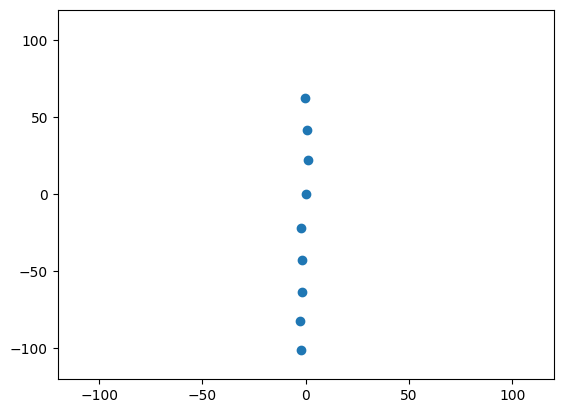

In [64]:
coords = bhv[:2, 2, -9:, 0].T
coords
fig, ax = plt.subplots()
ax.scatter(coords[:, 0], coords[:, 1])
ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)

# Compute angles between each node and its rostral node
angles = []
for i in range(1, len(coords)):
    dx = coords[i][0] - coords[i-1][0]
    dy = coords[i][1] - coords[i-1][1]
    angle = (np.pi/2) + np.arctan2(dy, dx)  # Angle in radians
    angles.append(angle)
angles

In [12]:
decoder_dir = "./ZebRep"
viewer = Viewer()
wid = PoserWidget(viewer)
viewer.window.add_dock_widget(wid, area='right')
wid.decoder_dir_picker.value = decoder_dir
wid.chkpt_dropdown.choices#best checkpoint is last one
chkpt = wid.chkpt_dropdown.choices[-1]


# frame by frame only because zeb rep is just angles not points
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = os.path.join(decoder_dir+"/lightning_logs", chkpt)
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


CTVM = convert_dlc_to_ctvm(dlc_file)
window_size =( 330. / 8 ) * 2
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 300, center_node = 13, preprocess_frame=True, window_size = 14)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

Video File Changed to c:\Users\pierc\Documents\DecoderData
Layers remaining are []
Layers remaining are []
Decoder Data Folder is c:\Users\pierc\Documents\DecoderData\ZebRep
Center node is 0
Number of nodes is 8
not regression
transform is None
Augmenting data True
Label dict is {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12}
decoder config is {'data_cfg': {'T': 'window', 'V': 8, 'fps': 700.0, 'T2': 600, 'numLabels': 13, 'denominator': 8, 'center': 0, 'classification_dict': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13}, 'augmentation': True, 'labels_to_ignore': 'None', 'calc_class_weights': False, 'weighted_random_sampler': True}, 'train_cfg': {'devices': 1, 'auto_lr': True, 'accelerator': 'gpu', 'graph_layout': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]], 'dropout': 0, 'num_channels': 1, 'num_workers': 0, 'transform': 'None', 'backbone': 'ST-GCN', 'early_stop_metric': 'auprc', 'early_stop_mode':

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Binary is False
[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Augment is False
STAGE IS predict
Predicting DataLoader 0:   0%|          | 0/48755 [00:00<?, ?it/s]

RuntimeError: running_mean should contain 57 elements not 8

In [13]:
CTVM.shape

(3, 780065, 19, 1)

#### ZebTensor

In [ ]:
decoder_dir = "./ZebTensor"
wid.decoder_dir_picker.value = decoder_dir
wid.chkpt_dropdown.choices#best checkpoint is last one
chkpt = wid.chkpt_dropdown.choices[-1]
# test the model on test data set
# test the model on one video of length 40 minutes filmed at 330 fps under 2 conditions; every frame and only extracted bouts
# 1) Load dlc file, 2) extract bouts, 3) convert to ctvm, 4) predict, 5) plot

dlc_file = r"C:\Users\pierc\Documents\DecoderData\ZebLR\Fish85_Wik_7dpf_330HzDLC_resnet50_Zeb2_0Feb4shuffle1_500000.h5"
vid_file = r"C:\Users\pierc\Documents\DecoderData\ZebLR\Fish85_Wik_7dpf_330Hz.avi"
wid.h5_picker.value = dlc_file
wid.vid_picker.value = vid_file
#wid.h5_picker_changed(dlc_file)
#wid.vid_picker_changed(vid_file)
wid.ind_spinbox.value = 1

start_time = time.time()
wid.extract_behaviours()
wid.analyse(None)
end_time = time.time()
duration = end_time - start_time
print(f"Bout analysis took {duration} seconds")

# frame by frame
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = os.path.join(decoder_dir+"/lightning_logs", chkpt)
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


CTVM = convert_dlc_to_ctvm(dlc_file)
window_size =( 330. / 8 ) * 2
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 300, center_node = 13, preprocess_frame=True, window_size = window_size)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

Extracting behaviours using orth method
Layers remaining are []


C:\Users\pierc\OneDrive\Documents\PoseR\src\poser\_widget.py:1011: RuntimeWarning: invalid value encountered in divide
  (np.sum(future_trajectory * present_orth, axis=1))


Augment is False


GPU available: True (cuda), used: True


not regression
transform is None
Augmenting data True
Label dict is {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}
Binary is False
Binary is False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 55/55 [00:02<00:00, 22.04it/s]
Total prediction time: 2.5009 seconds
tensor([[ -6.4343,  -9.7905, -16.6801,  ...,   1.2355,  -9.4220, -13.4278],
        [ -4.4122,  -8.4740, -17.7396,  ...,   2.2757,  -8.8064, -16.1102],
        [ -6.7953,  -5.0657,   0.0972,  ...,  -7.6794,   1.8116,  -6.0543],
        ...,
        [ -9.6416, -13.0053,  -7.4831,  ...,  -8.7616, -13.3212,  -8.4534],
        [  1.8120,   2.0737,   5.0664,  ...,  -5.0763,   1.5970,  -3.8946],
        [  4.2305,   5.3105,   7.0496,  ...,  -2.6096,   2.2079,  -3.6692]])
<class 'numpy.ndarray'>
predictions is [27 27 28 27 27  2 15 23 27 27 27  8 14  2 17 17 27 27  8 27 27 27 27 27
 27  8  6 14 11 27 14 17 17 27 20 14  0  5  0 22 17 14 28  1  1 13  1  3
  3 22  1 24  1 25  5  8  3 11 24  2  2  2  2  2 22  2 10 24 22  2  2  2
  2 28  2  2  2 24 24  2 22  2  2  2 24  3 24  8  5 27 27  6  8 22  5 12
  8  5 17 25 12  5  5 19 12  8  8  8  8 12 22 12 25 25  5  5 12 22 22  

c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Bout analysis took 8.293855667114258 seconds
Binary is False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Augment is False
STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 48755/48755 [32:36<00:00, 24.92it/s]
Total prediction time: 1956.4223 seconds


[tensor([[-31.8712, -32.3666, -35.2342,  20.2084, -35.5097,  14.4459, -27.4072,
          -13.0523, -33.7243, -19.8049,  -6.8042, -14.6336, -26.3137, -38.0160,
          -39.0607, -34.8296, -17.0914, -33.4104,  -6.1374, -27.0215, -17.3489,
          -35.0298,   0.3894, -45.5768, -34.6657, -37.3112, -54.0480],
         [-33.9387, -34.9021, -38.3179,  19.9167, -36.7869,  11.7101, -25.2341,
           -7.7332, -33.2445, -18.2738,  -8.0290, -18.3008, -26.2549, -39.7809,
          -42.1710, -32.6824, -15.6757, -38.6493,  -6.0951, -24.8725, -21.2083,
          -34.2098,   1.1676, -47.5532, -37.7679, -40.7805, -53.7594],
         [-31.2156, -31.0865, -31.9993,  19.1466, -32.9473,   9.7846, -22.5556,
          -11.5113, -30.7966, -16.9884,  -7.1667, -18.1090, -23.6672, -34.1668,
          -39.4208, -28.5149, -12.8342, -36.0985,  -7.3353, -24.3506, -18.8516,
          -29.6880,   1.9206, -41.9423, -37.2463, -36.8089, -46.2827],
         [-28.2473, -29.6290, -32.5524,  12.8638, -29.5255,   4.681

#### OFT

In [68]:
decoder_dir = "./Sturman/OFT/preprint/full"
wid.decoder_dir_picker.value = decoder_dir
dlc_file = r"C:\Users\pierc\Documents\DecoderData\Sturman\OFT\data\3_01_A_190507121945DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv"
# frame by frame
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = r"C:\Users\pierc\Documents\DecoderData\Sturman\OFT\preprint\full\lightning_logs\version_30\epoch=3-val_loss=0.53-val_acc=0.80--auprc=0.71--elapsed_time=105.33.ckpt"
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


CTVM = convert_dlc_to_ctvm(dlc_file)
window_size = 25
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 300, center_node = 10, preprocess_frame=True, window_size = window_size)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

New individual is individual 0
Video File Changed to c:\Users\pierc\Documents\DecoderData
updating slider
Event
updating slider frame 1
updating slider
Event
updating slider frame 1
updating slider
Event
updating slider frame 0
Layers remaining are []
Layers remaining are []
Decoder Data Folder is c:\Users\pierc\Documents\DecoderData\Sturman\OFT\preprint\full
Center node is 5
Number of nodes is 18
not regression
transform is None
Augmenting data True
Label dict is {0: 0, 1: 1, 2: 2}
decoder config is {'data_cfg': {'T': 'None', 'V': 18, 'fps': 25, 'T2': 300, 'numLabels': 3, 'denominator': 8, 'center': 5, 'head': 0, 'classification_dict': {0: 0, 1: 1, 2: 2}, 'augmentation': True, 'calc_class_weights': False, 'weighted_random_sampler': True, 'ideal_sample_no': 5000, 'labels_to_ignore': 'None', 'dataset': 'OFT_full', 'keypoints': ['nose', 'headcentre', 'neck', 'earl', 'earr', 'bodycentre', 'bcl', 'bcr', 'hipl', 'hipr', 'tailbase', 'tailcentre', 'tailtip']}, 'train_cfg': {'devices': 1, 'aut

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Augment is False
STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 954/954 [00:36<00:00, 25.93it/s]
Total prediction time: 36.8034 seconds


[tensor([[  16.9663, -200.9750,  148.2039],
         [  14.8823, -199.7520,  147.7348],
         [  13.3437, -199.1248,  147.7967],
         [  11.1671, -188.3636,  141.0210],
         [   9.8028, -176.5058,  132.1093],
         [   7.3670, -165.3398,  125.0869],
         [   6.4327, -152.3955,  114.8613],
         [   4.5083, -139.9721,  106.1179],
         [   3.8326, -126.5569,   95.2612],
         [   1.8004, -114.4688,   86.9754],
         [   0.7522, -101.7832,   77.1953],
         [  -1.3882,  -90.3150,   69.7243],
         [  -2.4238,  -81.8094,   64.8087],
         [  -5.2116,  -70.0519,   57.1277],
         [  -4.2221,  -62.6708,   51.7798],
         [  -7.5627,  -49.1688,   42.2218]]),
 tensor([[ -6.7982, -40.5713,  34.3494],
         [ -6.2024, -34.7931,  28.9459],
         [ -5.2110, -33.6887,  27.0320],
         [ -6.4006, -35.2592,  29.5659],
         [ -5.8273, -34.0391,  27.8802],
         [  1.1791, -39.2674,  29.0138],
         [  1.6804, -37.9779,  27.1600],
       

In [73]:
vid_length = zebdata.T0 / 25
vid_length, zebdata.T0

(610.12, 15253)

#### FlyVFly

In [79]:
decoder_dir = "./FlyvFly/hypergraph"

kps = np.load('./FlyvFly/fly_train_keypoints.npz', allow_pickle = True)

x_idx = [0, 5, 7] # centroid pos x,  wing l x, wing r x
y_idx = [1, 6, 8] # centroid pos y, wing l y, wing r y
nctvms = []
vid = 0

# reorder keypoints to N, C, T, V, M
TMX = kps["keypoints"][vid][:, :, x_idx]  #NMX

TMY = kps["keypoints"][vid][:, :, y_idx]

# convert to TCMV
CTMV = np.stack([TMX, TMY], axis=0)
# convert to CTVM
CTVM = np.swapaxes(CTMV, 2, 3)
C, T, V, M = CTVM.shape # should be 2, 49406, 3, 2
CTVM = CTVM.reshape((C, T, V*M, 1), order = "F")

# frame by frame
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = r"C:\Users\pierc\Documents\DecoderData\FlyvFly\hypergraph\lightning_logs\version_20\epoch=12-val_loss=0.09-val_acc=0.97--auprc=0.71.ckpt"
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


window_size = 14
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 100, center_node = 2, preprocess_frame=True, window_size = window_size)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [3, 1], [3, 2]]
Augment is False
STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 3088/3088 [00:18<00:00, 168.76it/s]
Total prediction time: 18.3017 seconds


[tensor([[ -6.5261, -17.4431,   0.4009,  -9.1160, -16.9300,   0.6160],
         [ -7.0061, -16.7065,  -1.8744,  -8.2429, -20.9327,   1.8682],
         [ -6.9804, -15.4173,  -5.1590,  -8.1244, -23.1827,   3.6142],
         [ -6.8019, -14.2878,  -7.3877,  -8.3817, -26.4874,   5.4447],
         [ -5.7744, -13.0156, -11.2506,  -8.3213, -28.0951,   8.2578],
         [ -5.0263, -11.8525, -15.3442,  -9.4527, -29.8815,   9.9828],
         [ -2.6605, -10.6104, -21.3590, -10.7224, -32.1745,  12.3521],
         [ -1.4567,  -7.6957, -27.8063, -11.2077, -22.1268,   9.6235],
         [  6.7017,   5.6242, -49.9001, -16.8705, -52.4116,  15.3516],
         [  6.6892,   5.6589, -49.8952, -16.8499, -52.4263,  15.3618],
         [  6.6339,   5.7542, -49.7936, -16.8168, -52.3863,  15.3908],
         [  6.6557,   5.7279, -49.8359, -16.8246, -52.4259,  15.3825],
         [  6.6959,   5.6654, -49.9111, -16.8434, -52.4869,  15.3617],
         [  6.7091,   5.6462, -49.9430, -16.8500, -52.4985,  15.3565],
      

In [81]:
zebdata.T0 / 30 / 60, zebdata.T0

(27.447777777777777, 49406)

In [ ]:
CTVM.reshape()

(2, 49406, 3, 2)

#### CALMS21

#### PAIRR24M

In [84]:
keypoint_path = r"Z:\mfz\Pierce\DeepLabCut\DecoderData\PAIRR24MDataset\PAIR-R24M-Dataset\20210119_Recording_SR1_SR2_social_vidtwo\markerDataset.csv"
marker_dataset = pd.read_csv(keypoint_path)
V=12
C=3
M=2
# abs an1 columns
abs_an1_cols = [col for col in marker_dataset.columns if ("an1" in col) & ("absolute" in col)] #xyz order
abs_an2_cols = [col for col in marker_dataset.columns if ("an2" in col) & ("absolute" in col)]

T = marker_dataset.shape[0]
quality = marker_dataset.loc[:, ["goodFrame_an1", "goodFrame_an2"]].astype(bool).all(axis=1).to_numpy()
xyz_an1 = marker_dataset.loc[:, abs_an1_cols].to_numpy().reshape((-1, V, C))
xyz_an2 = marker_dataset.loc[:, abs_an2_cols].to_numpy().reshape((-1, V, C))
CTVM =np.stack([np.swapaxes(np.swapaxes(xyz_an1, 1, 2), 0, 1), np.swapaxes(np.swapaxes(xyz_an2, 1, 2), 0, 1)], axis=-1)
CTVM = CTVM.reshape((C, T, V*M, 1), order = "F")
CTVM.shape


# frame by frame
from poser.utils import convert_dlc_to_ctvm
from poser._loader import ZebData
from poser.models import st_gcn_aaai18_pylightning_3block

from pytorch_lightning import Trainer
import os
# softmax those predictions


chkpt_path = r"C:\Users\pierc\Documents\DecoderData\PAIRR24MDataset\social_hypergraph\lightning_logs\version_20\epoch=5-val_loss=0.52-val_acc=0.82--auprc=0.65.ckpt"
model = st_gcn_aaai18_pylightning_3block.ST_GCN_18.load_from_checkpoint(chkpt_path)

trainer = Trainer(accelerator= "gpu")

model.freeze()


window_size = 14
zebdata = ZebData(transform = ["flipy", "center", "align", "pad"], T = 100, center_node = 2, preprocess_frame=True, window_size = window_size)
zebdata.data = CTVM
zebdata.labels = np.zeros(CTVM.shape[1])
zebdata.C, zebdata.T0, zebdata.V, zebdata.M = CTVM.shape


dataloader = DataLoader(zebdata, batch_size=16, shuffle=False)
trainer.predict(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pierc\anaconda3\envs\PoseR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


[[0, 1], [0, 2], [1, 3], [2, 3], [3, 10], [3, 11], [3, 6], [3, 4], [4, 6], [6, 7], [4, 7], [4, 5], [7, 5], [5, 8], [5, 9], [12, 13], [12, 14], [13, 15], [14, 15], [15, 22], [15, 23], [15, 18], [15, 16], [16, 18], [18, 19], [16, 19], [16, 17], [19, 17], [17, 20], [17, 21], [0, 12], [1, 13], [2, 14], [10, 22], [11, 23], [6, 18], [4, 15], [7, 16], [5, 17], [8, 20], [9, 21], [0, 22], [0, 15], [12, 4]]
Augment is False
STAGE IS predict
Predicting DataLoader 0: 100%|██████████| 6750/6750 [01:52<00:00, 60.11it/s]
Total prediction time: 112.2948 seconds


[tensor([[  1.7562,  -5.7853,  -8.4244, -16.8329],
         [  1.9698,  -6.0393,  -7.6348, -17.6334],
         [  1.8142,  -5.3440,  -6.4729, -18.2571],
         [  1.4251,  -4.1188,  -4.8253, -18.5424],
         [  0.6102,  -3.3096,  -2.7732, -17.1766],
         [ -0.4712,  -3.7588,   0.1787, -15.4063],
         [ -1.6874,  -4.0373,  -1.8166, -13.6402],
         [ -1.4791,   0.5817, -24.3428,  -7.8127],
         [ -2.4020,   0.7015, -21.2410,  -8.0405],
         [ -2.6697,   0.9283, -22.1933,  -7.4024],
         [ -2.6373,   1.1830, -24.9474,  -6.7730],
         [ -2.5198,   1.3433, -27.8386,  -6.1086],
         [ -2.4059,   1.3752, -30.7479,  -5.3482],
         [ -2.3106,   1.2535, -33.5717,  -4.5020],
         [ -2.1803,   1.1589, -36.3114,  -3.8160],
         [ -2.0382,   1.0799, -38.6865,  -3.1599]]),
 tensor([[ -1.8673,   0.9068, -40.6097,  -2.6668],
         [ -1.7031,   0.6117, -42.0233,  -2.2252],
         [ -1.3182,   0.2022, -43.8372,  -1.7868],
         [ -0.5907,  -0.6835,

In [88]:
np.load(r"Z:\mfz\Pierce\DeepLabCut\DecoderData\ZebLarvae2.0\v2\lightning_logs\version_0\inference_latencies_TitanGPU.npy").mean()
np.load(r"Z:\mfz\Pierce\DeepLabCut\DecoderData\ZebLarvae2.0\v2\lightning_logs\version_0\inference_latencies_TitanGPU.npy").std()

0.21594965542554304

In [85]:
zebdata.T0 / 30 / 60, zebdata.T0

(60.0, 108000)